This notebook contains an implementation of the One Hundred Layers Tiramisu as described in Simon Jegou et al.'s paper [The One Hundred Layers Tiramisu: Fully Convolutional DenseNets for Semantic Segmentation](https://arxiv.org/abs/1611.09326). 

In [2]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

In [2]:
import warnings

warnings.filterwarnings("ignore",category=DeprecationWarning)


In [3]:
limit_mem()

# Tiramisu / Camvid

Tiramisu is a fully-convolutional neural network based on DenseNet architecture. It was designed as a state-of-the-art approach to semantic image segmentation.

We're going to use the same dataset they did, CamVid.

CamVid is a dataset of images from a video. It has ~ 600 images, so it's quite small, and given that it is from a video the information content of the dataset is small. 

We're going to train this Tiramisu network from scratch to segment the CamVid dataset. This seems extremely ambitious!

## Setup

Modify the following to point to the appropriate paths on your machine

In [4]:
PATH = '/data/datasets/SegNet-Tutorial/CamVid/'

In [5]:
frames_path = PATH+'all/'

In [6]:
labels_path = PATH+'allannot/'

In [7]:
PATH = '/data/datasets/camvid/'

The images in CamVid come with labels defining the segments of the input image. We're going to load both the images and the labels.

In [8]:
frames_path = PATH+'701_StillsRaw_full/'

In [9]:
labels_path = PATH+'LabeledApproved_full/'

In [10]:
fnames = glob.glob(frames_path+'*.png')

In [11]:
lnames = [labels_path+os.path.basename(fn)[:-4]+'_L.png' for fn in fnames]

In [12]:
img_sz = (480,360)

Helper function to resize images.

In [13]:
def open_image(fn): return np.array(Image.open(fn).resize(img_sz, Image.NEAREST))

In [14]:
img = Image.open(fnames[0]).resize(img_sz, Image.NEAREST)

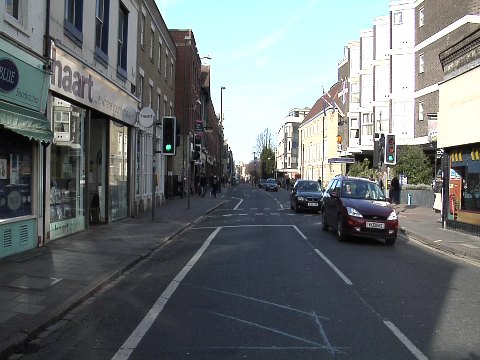

In [15]:
img

In [70]:
imgs = np.stack([open_image(fn) for fn in fnames])

In [71]:
labels = np.stack([open_image(fn) for fn in lnames])

In [72]:
imgs.shape,labels.shape

((701, 360, 480, 3), (701, 360, 480, 3))

Normalize pixel values.

Save array for easier use.

In [200]:
save_array(PATH+'results/imgs.bc', imgs)
save_array(PATH+'results/labels.bc', labels)

In [10]:
imgs = load_array(PATH+'results/imgs.bc')
labels = load_array(PATH+'results/labels.bc')

Standardize

In [11]:
imgs-=0.4
imgs/=0.3

In [12]:
n,r,c,ch = imgs.shape

## Preprocessing

### Generator

This implementation employs data augmentation on CamVid. 

Augmentation includes random cropping / horizontal flipping, as done by `segm_generator()`. `BatchIndices()` lets us randomly sample batches from input array.

In [13]:
class BatchIndices(object):
    def __init__(self, n, bs, shuffle=False):
        self.n,self.bs,self.shuffle = n,bs,shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n) 
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0

    def __next__(self):
        with self.lock:
            if self.curr >= self.n: self.reset()
            ni = min(self.bs, self.n-self.curr)
            res = self.idxs[self.curr:self.curr+ni]
            self.curr += ni
            return res

In [14]:
bi = BatchIndices(10,3)
[next(bi) for o in range(5)]

[array([0, 1, 2]),
 array([3, 4, 5]),
 array([6, 7, 8]),
 array([9]),
 array([0, 1, 2])]

In [15]:
bi = BatchIndices(10,3,True)
[next(bi) for o in range(5)]

[array([3, 9, 2]),
 array([0, 6, 8]),
 array([7, 1, 4]),
 array([5]),
 array([8, 0, 5])]

In [16]:
class segm_generator(object):
    def __init__(self, x, y, bs=64, out_sz=(224,224), train=True):
        self.x, self.y, self.bs, self.train = x,y,bs,train
        self.n, self.ri, self.ci, _ = x.shape
        self.idx_gen = BatchIndices(self.n, bs, train)
        self.ro, self.co = out_sz
        self.ych = self.y.shape[-1] if len(y.shape)==4 else 1

    def get_slice(self, i,o):
        start = random.randint(0, i-o) if self.train else (i-o)
        return slice(start, start+o)

    def get_item(self, idx):
        slice_r = self.get_slice(self.ri, self.ro)
        slice_c = self.get_slice(self.ci, self.co)
        x = self.x[idx, slice_r, slice_c]
        y = self.y[idx, slice_r, slice_c]
        if self.train and (random.random()>0.5): 
            y = y[:,::-1]
            x = x[:,::-1]
        return x, y

    def __next__(self):
        idxs = next(self.idx_gen)
        items = (self.get_item(idx) for idx in idxs)
        xs,ys = zip(*items)
        return np.stack(xs), np.stack(ys).reshape(len(ys), -1, self.ych)

As an example, here's a crop of the first image.

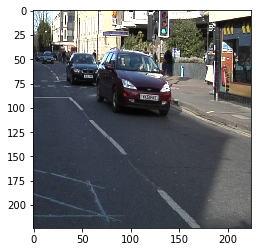

In [17]:
sg = segm_generator(imgs, labels, 4, train=False)
b_img, b_label = next(sg)
plt.imshow(b_img[0]*0.3+0.4);

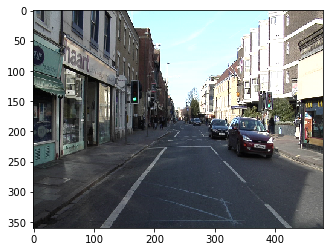

In [18]:
plt.imshow(imgs[0]*0.3+0.4);

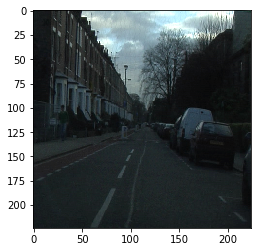

In [26]:
sg = segm_generator(imgs, labels, 4, train=True)
b_img, b_label = next(sg)
plt.imshow(b_img[0]*0.3+0.4);

### Convert labels

The following loads, parses, and converts the segment labels we need for targets.

In particular we're looking to make the segmented targets into integers for classification purposes.

In [27]:
def parse_code(l):
    a,b = l.strip().split("\t")
    return tuple(int(o) for o in a.split(' ')), b

In [28]:
label_codes,label_names = zip(*[
    parse_code(l) for l in open(PATH+"label_colors.txt")])

In [29]:
label_codes,label_names = list(label_codes),list(label_names)

Each segment / category is indicated by a particular color. The following maps each unique pixel to it's category.

In [189]:
list(zip(label_codes,label_names))[:5]

[((64, 128, 64), 'Animal'),
 ((192, 0, 128), 'Archway'),
 ((0, 128, 192), 'Bicyclist'),
 ((0, 128, 64), 'Bridge'),
 ((128, 0, 0), 'Building')]

We're going to map each unique pixel color to an integer so we can classify w/ our NN. (Think how a fill-in-the color image looks)

In [30]:
code2id = {v:k for k,v in enumerate(label_codes)}

We'll include an integer for erroneous pixel values.

In [31]:
failed_code = len(label_codes)+1

In [32]:
label_codes.append((0,0,0))
label_names.append('unk')

In [33]:
def conv_one_label(i): 
    res = np.zeros((r,c), 'uint8')
    for j in range(r): 
        for k in range(c):
            try: res[j,k] = code2id[tuple(labels[i,j,k])]
            except: res[j,k] = failed_code
    return res

In [34]:
from concurrent.futures import ProcessPoolExecutor

In [35]:
def conv_all_labels():
    ex = ProcessPoolExecutor(8)
    return np.stack(ex.map(conv_one_label, range(n)))

Now we'll create integer-mapped labels for all our colored images.

In [197]:
%time labels_int =conv_all_labels()

CPU times: user 548 ms, sys: 568 ms, total: 1.12 s
Wall time: 2min


In [198]:
np.count_nonzero(labels_int==failed_code)

44

Set erroneous pixels to zero.

In [199]:
labels_int[labels_int==failed_code]=0

In [111]:
save_array(PATH+'results/labels_int.bc', labels_int)

In [36]:
labels_int = load_array(PATH+'results/labels_int.bc')

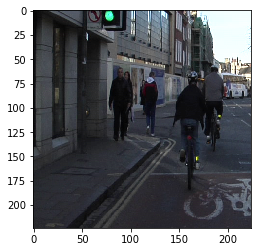

In [37]:
sg = segm_generator(imgs, labels, 4, train=True)
b_img, b_label = next(sg)
plt.imshow(b_img[0]*0.3+0.4);

Here is an example of how the segmented image looks.

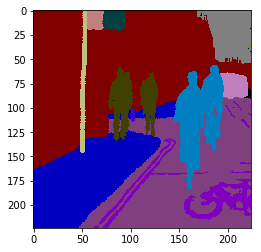

In [38]:
plt.imshow(b_label[0].reshape(224,224,3));

### Test set

Next we load test set, set training/test images and labels.

In [39]:
fn_test = set(o.strip() for o in open(PATH+'test.txt','r'))

In [40]:
is_test = np.array([o.split('/')[-1] in fn_test for o in fnames])

In [41]:
trn = imgs[is_test==False]
trn_labels = labels_int[is_test==False]
test = imgs[is_test]
test_labels = labels_int[is_test]
trn.shape,test_labels.shape

((468, 360, 480, 3), (233, 360, 480))

In [42]:
rnd_trn = len(trn_labels)
rnd_test = len(test_labels)

## The Tiramisu

Now that we've prepared our data, we're ready to introduce the Tiramisu.

Conventional CNN's for image segmentation are very similar to the kind we looked at for style transfer. Recall that it involved convolutions with downsampling (stride 2, pooling) to increase the receptive field, followed by upsampling with deconvolutions until reaching the original side. 

Tiramisu uses a similar down / up architecture, but with some key caveats.

As opposed to normal convolutional layers, Tiramisu uses the DenseNet method of concatenating inputs to outputs. Tiramisu also uses *skip connections* from the downsampling branch to the upsampling branch.

Specifically, the *skip connection* functions by concatenating the output of a Dense block in the down-sampling branch **onto** the input of the corresponding Dense block in the upsampling branch. By "corresponding", we mean the down-sample/up-sample Dense blocks that are equidistant from the input / output respectively.

One way of interpreting this architecture is that by re-introducing earlier stages of the network to later stages, we're forcing the network to "remember" the finer details of the input image.

### The pieces

This should all be familiar.

In [43]:
def relu(x): return Activation('relu')(x)
def dropout(x, p): return Dropout(p)(x) if p else x
def bn(x): return BatchNormalization(mode=2, axis=-1)(x)
def relu_bn(x): return relu(bn(x))
def concat(xs): return merge(xs, mode='concat', concat_axis=-1)

In [44]:
def conv(x, nf, sz, wd, p, stride=1): 
    x = Convolution2D(nf, sz, sz, init='he_uniform', border_mode='same', 
                      subsample=(stride,stride), W_regularizer=l2(wd))(x)
    return dropout(x, p)

def conv_relu_bn(x, nf, sz=3, wd=0, p=0, stride=1): 
    return conv(relu_bn(x), nf, sz, wd=wd, p=p, stride=stride)

Recall the dense block from DenseNet.

In [45]:
def dense_block(n,x,growth_rate,p,wd):
    added = []
    for i in range(n):
        b = conv_relu_bn(x, growth_rate, p=p, wd=wd)
        x = concat([x, b])
        added.append(b)
    return x,added

This is the downsampling transition. 

In the original paper, downsampling consists of 1x1 convolution followed by max pooling. However we've found a stride 2 1x1 convolution to give better results.

In [46]:
def transition_dn(x, p, wd):
#     x = conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd)
#     return MaxPooling2D(strides=(2, 2))(x)
    return conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd, stride=2)

Next we build the entire downward path, keeping track of Dense block outputs in a list called `skip`. 

In [47]:
def down_path(x, nb_layers, growth_rate, p, wd):
    skips = []
    for i,n in enumerate(nb_layers):
        x,added = dense_block(n,x,growth_rate,p,wd)
        skips.append(x)
        x = transition_dn(x, p=p, wd=wd)
    return skips, added

This is the upsampling transition. We use a deconvolution layer.

In [48]:
def transition_up(added, wd=0):
    x = concat(added)
    _,r,c,ch = x.get_shape().as_list()
    return Deconvolution2D(ch, 3, 3, (None,r*2,c*2,ch), init='he_uniform', 
               border_mode='same', subsample=(2,2), W_regularizer=l2(wd))(x)
#     x = UpSampling2D()(x)
#     return conv(x, ch, 2, wd, 0)

This builds our upward path, concatenating the skip connections from `skip` to the Dense block inputs as mentioned.

In [49]:
def up_path(added, skips, nb_layers, growth_rate, p, wd):
    for i,n in enumerate(nb_layers):
        x = transition_up(added, wd)
        x = concat([x,skips[i]])
        x,added = dense_block(n,x,growth_rate,p,wd)
    return x

### Build the tiramisu model

- nb_classes: number of classes
- img_input: tuple of shape (channels, rows, columns) or (rows, columns, channels)
- depth: number or layers
- nb_dense_block: number of dense blocks to add to end (generally = 3)
- growth_rate: number of filters to add per dense block
- nb_filter:  initial number of filters
- nb_layers_per_block: number of layers in each dense block.
  - If positive integer, a set number of layers per dense block.
  - If list, nb_layer is used as provided
- p: dropout rate
- wd: weight decay

In [53]:
def reverse(a): return list(reversed(a))

Finally we put together the entire network.

In [54]:
def create_tiramisu(nb_classes, img_input, nb_dense_block=6, 
    growth_rate=16, nb_filter=48, nb_layers_per_block=5, p=None, wd=0):
    
    if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
        nb_layers = list(nb_layers_per_block)
    else: nb_layers = [nb_layers_per_block] * nb_dense_block

    x = conv(img_input, nb_filter, 3, wd, 0)
    skips,added = down_path(x, nb_layers, growth_rate, p, wd)
    x = up_path(added, reverse(skips[:-1]), reverse(nb_layers[:-1]), growth_rate, p, wd)
    
    x = conv(x, nb_classes, 1, wd, 0)
    _,r,c,f = x.get_shape().as_list()
    x = Reshape((-1, nb_classes))(x)
    return Activation('softmax')(x)

## Train

Now we can train. 

These architectures can take quite some time to train.

In [55]:
limit_mem()

In [247]:
input_shape = (224,224,3)

In [248]:
img_input = Input(shape=input_shape)

In [249]:
x = create_tiramisu(12, img_input, nb_layers_per_block=[4,5,7,10,12,15], p=0.2, wd=1e-4)

In [250]:
model = Model(img_input, x)

In [251]:
gen = segm_generator(trn, trn_labels, 3, train=True)

In [252]:
gen_test = segm_generator(test, test_labels, 3, train=False)

In [253]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=keras.optimizers.RMSprop(1e-3), metrics=["accuracy"])

In [253]:
model.optimizer=keras.optimizers.RMSprop(1e-3, decay=1-0.99995)

In [254]:
model.optimizer=keras.optimizers.RMSprop(1e-3)

In [193]:
K.set_value(model.optimizer.lr, 1e-3)

In [254]:
model.fit_generator(gen, rnd_trn, 100, verbose=2, 
                    validation_data=gen_test, nb_val_samples=rnd_test)

Epoch 1/100
157s - loss: 2.1389 - acc: 0.4892 - val_loss: 1.6624 - val_acc: 0.6085
Epoch 2/100
118s - loss: 1.5712 - acc: 0.5587 - val_loss: 1.4721 - val_acc: 0.5744
Epoch 3/100
118s - loss: 1.3876 - acc: 0.5933 - val_loss: 1.3957 - val_acc: 0.5910
Epoch 4/100
118s - loss: 1.2609 - acc: 0.6235 - val_loss: 1.1526 - val_acc: 0.6347
Epoch 5/100
118s - loss: 1.1995 - acc: 0.6446 - val_loss: 1.0778 - val_acc: 0.6720
Epoch 6/100
118s - loss: 1.0979 - acc: 0.6817 - val_loss: 1.3923 - val_acc: 0.6249
Epoch 7/100
118s - loss: 1.0422 - acc: 0.7013 - val_loss: 1.0302 - val_acc: 0.7009
Epoch 8/100
118s - loss: 1.0270 - acc: 0.7130 - val_loss: 0.9736 - val_acc: 0.7334
Epoch 9/100
118s - loss: 0.9680 - acc: 0.7282 - val_loss: 1.0661 - val_acc: 0.6739
Epoch 10/100
118s - loss: 0.9573 - acc: 0.7372 - val_loss: 0.9459 - val_acc: 0.7260
Epoch 11/100
118s - loss: 0.9348 - acc: 0.7397 - val_loss: 1.0048 - val_acc: 0.7182
Epoch 12/100
118s - loss: 0.8715 - acc: 0.7603 - val_loss: 1.0600 - val_acc: 0.6993
E

In [256]:
model.optimizer=keras.optimizers.RMSprop(3e-4, decay=1-0.9995)

In [257]:
model.fit_generator(gen, rnd_trn, 500, verbose=2, 
                    validation_data=gen_test, nb_val_samples=rnd_test)

Epoch 1/500
135s - loss: 0.3903 - acc: 0.9023 - val_loss: 0.5612 - val_acc: 0.8492
Epoch 2/500
117s - loss: 0.3869 - acc: 0.9030 - val_loss: 0.5668 - val_acc: 0.8451
Epoch 3/500
117s - loss: 0.3744 - acc: 0.9065 - val_loss: 0.5616 - val_acc: 0.8484
Epoch 4/500
117s - loss: 0.3821 - acc: 0.9047 - val_loss: 0.5417 - val_acc: 0.8549
Epoch 5/500
117s - loss: 0.3731 - acc: 0.9063 - val_loss: 0.5656 - val_acc: 0.8487
Epoch 6/500
117s - loss: 0.3729 - acc: 0.9069 - val_loss: 0.5817 - val_acc: 0.8420
Epoch 7/500
117s - loss: 0.3693 - acc: 0.9066 - val_loss: 0.5599 - val_acc: 0.8513
Epoch 8/500
117s - loss: 0.3734 - acc: 0.9053 - val_loss: 0.5822 - val_acc: 0.8434
Epoch 9/500
117s - loss: 0.3664 - acc: 0.9078 - val_loss: 0.5427 - val_acc: 0.8542
Epoch 10/500
117s - loss: 0.3635 - acc: 0.9080 - val_loss: 0.5556 - val_acc: 0.8493
Epoch 11/500
117s - loss: 0.3683 - acc: 0.9068 - val_loss: 0.5481 - val_acc: 0.8555
Epoch 12/500
117s - loss: 0.3643 - acc: 0.9079 - val_loss: 0.5862 - val_acc: 0.8431
E

KeyboardInterrupt: 

In [258]:
model.optimizer=keras.optimizers.RMSprop(2e-4, decay=1-0.9995)

In [259]:
model.fit_generator(gen, rnd_trn, 500, verbose=2, 
                    validation_data=gen_test, nb_val_samples=rnd_test)

Epoch 1/500
136s - loss: 0.3367 - acc: 0.9143 - val_loss: 0.5549 - val_acc: 0.8508
Epoch 2/500
117s - loss: 0.3432 - acc: 0.9119 - val_loss: 0.5744 - val_acc: 0.8429
Epoch 3/500
118s - loss: 0.3355 - acc: 0.9153 - val_loss: 0.5937 - val_acc: 0.8342
Epoch 4/500
117s - loss: 0.3441 - acc: 0.9115 - val_loss: 0.5675 - val_acc: 0.8379
Epoch 5/500
117s - loss: 0.3338 - acc: 0.9151 - val_loss: 0.5490 - val_acc: 0.8523
Epoch 6/500
117s - loss: 0.3390 - acc: 0.9132 - val_loss: 0.5408 - val_acc: 0.8520
Epoch 7/500
117s - loss: 0.3481 - acc: 0.9097 - val_loss: 0.5525 - val_acc: 0.8464
Epoch 8/500
117s - loss: 0.3434 - acc: 0.9125 - val_loss: 0.5431 - val_acc: 0.8538
Epoch 9/500
117s - loss: 0.3288 - acc: 0.9160 - val_loss: 0.6425 - val_acc: 0.8339
Epoch 10/500
117s - loss: 0.3368 - acc: 0.9133 - val_loss: 0.5633 - val_acc: 0.8376
Epoch 11/500
117s - loss: 0.3391 - acc: 0.9126 - val_loss: 0.5347 - val_acc: 0.8525
Epoch 12/500
117s - loss: 0.3249 - acc: 0.9176 - val_loss: 0.5775 - val_acc: 0.8413
E

KeyboardInterrupt: 

In [260]:
model.optimizer=keras.optimizers.RMSprop(1e-5, decay=1-0.9995)

In [261]:
model.fit_generator(gen, rnd_trn, 500, verbose=2, 
                    validation_data=gen_test, nb_val_samples=rnd_test)

Epoch 1/500
135s - loss: 0.2466 - acc: 0.9354 - val_loss: 0.5157 - val_acc: 0.8642
Epoch 2/500
117s - loss: 0.2629 - acc: 0.9290 - val_loss: 0.5258 - val_acc: 0.8581
Epoch 3/500
117s - loss: 0.2654 - acc: 0.9289 - val_loss: 0.4935 - val_acc: 0.8642
Epoch 4/500
118s - loss: 0.2555 - acc: 0.9323 - val_loss: 0.5139 - val_acc: 0.8575
Epoch 5/500
117s - loss: 0.2563 - acc: 0.9312 - val_loss: 0.5016 - val_acc: 0.8601
Epoch 6/500
117s - loss: 0.2600 - acc: 0.9308 - val_loss: 0.5194 - val_acc: 0.8602
Epoch 7/500
117s - loss: 0.2587 - acc: 0.9310 - val_loss: 0.5098 - val_acc: 0.8603
Epoch 8/500
117s - loss: 0.2628 - acc: 0.9300 - val_loss: 0.5219 - val_acc: 0.8579
Epoch 9/500
117s - loss: 0.2579 - acc: 0.9328 - val_loss: 0.4900 - val_acc: 0.8667
Epoch 10/500
117s - loss: 0.2590 - acc: 0.9305 - val_loss: 0.5170 - val_acc: 0.8603
Epoch 11/500
117s - loss: 0.2544 - acc: 0.9331 - val_loss: 0.5003 - val_acc: 0.8577
Epoch 12/500
117s - loss: 0.2550 - acc: 0.9320 - val_loss: 0.5210 - val_acc: 0.8555
E

KeyboardInterrupt: 

In [67]:
lrg_sz = (352,480)
gen = segm_generator(trn, trn_labels, 2, out_sz=lrg_sz, train=True)
gen_test = segm_generator(test, test_labels, 2, out_sz=lrg_sz, train=False)

In [68]:
lrg_shape = lrg_sz+(3,)
lrg_input = Input(shape=lrg_shape)

In [69]:
x = create_tiramisu(12, lrg_input, nb_layers_per_block=[4,5,7,10,12,15], p=0.2, wd=1e-4)

In [70]:
lrg_model = Model(lrg_input, x)

In [71]:
lrg_model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=keras.optimizers.RMSprop(1e-4), metrics=["accuracy"])

In [326]:
lrg_model.fit_generator(gen, rnd_trn, 100, verbose=2, 
                    validation_data=gen_test, nb_val_samples=rnd_test)

Epoch 1/100
393s - loss: 0.2116 - acc: 0.9453 - val_loss: 0.5031 - val_acc: 0.8720
Epoch 2/100
346s - loss: 0.2048 - acc: 0.9471 - val_loss: 0.4961 - val_acc: 0.8741
Epoch 3/100
346s - loss: 0.2032 - acc: 0.9476 - val_loss: 0.5058 - val_acc: 0.8703
Epoch 4/100
346s - loss: 0.1988 - acc: 0.9487 - val_loss: 0.5030 - val_acc: 0.8678
Epoch 5/100
346s - loss: 0.1985 - acc: 0.9487 - val_loss: 0.5042 - val_acc: 0.8727
Epoch 6/100
346s - loss: 0.1981 - acc: 0.9489 - val_loss: 0.4969 - val_acc: 0.8742
Epoch 7/100
346s - loss: 0.1955 - acc: 0.9494 - val_loss: 0.5067 - val_acc: 0.8693
Epoch 8/100
346s - loss: 0.1953 - acc: 0.9497 - val_loss: 0.5183 - val_acc: 0.8720
Epoch 9/100


KeyboardInterrupt: 

In [370]:
lrg_model.fit_generator(gen, rnd_trn, 100, verbose=2, 
                    validation_data=gen_test, nb_val_samples=rnd_test)

Epoch 1/100
377s - loss: 0.1894 - acc: 0.9511 - val_loss: 0.5339 - val_acc: 0.8654
Epoch 2/100
341s - loss: 0.1925 - acc: 0.9497 - val_loss: 0.5348 - val_acc: 0.8595
Epoch 3/100
342s - loss: 0.1865 - acc: 0.9521 - val_loss: 0.4922 - val_acc: 0.8751
Epoch 4/100
341s - loss: 0.1875 - acc: 0.9514 - val_loss: 0.5100 - val_acc: 0.8751
Epoch 5/100
341s - loss: 0.1902 - acc: 0.9509 - val_loss: 0.4954 - val_acc: 0.8755
Epoch 6/100
341s - loss: 0.1869 - acc: 0.9516 - val_loss: 0.5136 - val_acc: 0.8686
Epoch 7/100
342s - loss: 0.1899 - acc: 0.9504 - val_loss: 0.5182 - val_acc: 0.8734
Epoch 8/100
343s - loss: 0.1884 - acc: 0.9506 - val_loss: 0.5827 - val_acc: 0.8533
Epoch 9/100
344s - loss: 0.1843 - acc: 0.9529 - val_loss: 0.5236 - val_acc: 0.8715
Epoch 10/100
344s - loss: 0.1887 - acc: 0.9509 - val_loss: 0.5538 - val_acc: 0.8613
Epoch 11/100
344s - loss: 0.1843 - acc: 0.9523 - val_loss: 0.5364 - val_acc: 0.8686
Epoch 12/100
344s - loss: 0.1871 - acc: 0.9511 - val_loss: 0.5568 - val_acc: 0.8641
E

KeyboardInterrupt: 

In [371]:
lrg_model.optimizer=keras.optimizers.RMSprop(1e-5)

In [372]:
lrg_model.fit_generator(gen, rnd_trn, 2, verbose=2, 
                    validation_data=gen_test, nb_val_samples=rnd_test)

Epoch 1/2
367s - loss: 0.1873 - acc: 0.9510 - val_loss: 0.5111 - val_acc: 0.8729
Epoch 2/2
344s - loss: 0.1825 - acc: 0.9525 - val_loss: 0.4921 - val_acc: 0.8758


In [375]:
lrg_model.save_weights(PATH+'results/8758.h5')

## View results

Let's take a look at some of the results we achieved.

In [331]:
colors = [(128, 128, 128), (128, 0, 0), (192, 192, 128), (128, 64, 128), (0, 0, 192),
         (128, 128, 0), (192, 128, 128), (64, 64, 128), (64, 0, 128), (64, 64, 0),
         (0, 128, 192), (0, 0, 0)]
names = ['sky', 'building', 'column_pole', 'road', 'sidewalk', 'tree', 
                'sign', 'fence', 'car', 'pedestrian', 'bicyclist', 'void']

In [382]:
gen_test = segm_generator(test, test_labels, 2, out_sz=lrg_sz, train=False)

In [383]:
preds = lrg_model.predict_generator(gen_test, rnd_test)
preds = np.argmax(preds, axis=-1)
preds = preds.reshape((-1,352,480))

In [384]:
target = test_labels.reshape((233,360,480))[:,8:]

In [385]:
(target == preds).mean()

0.87580886148231241

In [386]:
non_void = target != 11
(target[non_void] == preds[non_void]).mean()

0.89557539296419497

In [135]:
idx=1

In [387]:
p=lrg_model.predict(np.expand_dims(test[idx,8:],0))
p = np.argmax(p[0],-1).reshape(352,480)
pred = color_label(p)

This is pretty good! We can see it is having some difficulty with the street between the light posts, but we would expect that a model that was pre-trained on a much larger dataset would perform better.

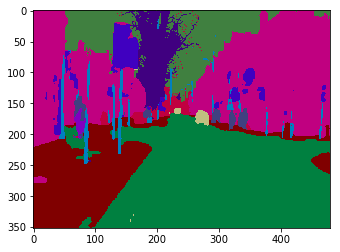

In [388]:
plt.imshow(pred);

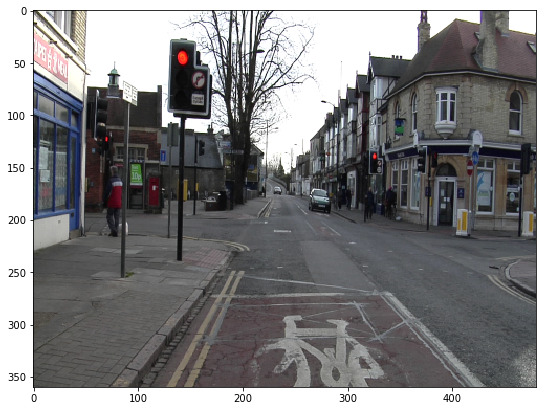

In [392]:
plt.figure(figsize=(9,9))
plt.imshow(test[idx]*0.3+0.4)

## End